#make feature matrix by finding the cosine similarities of tweets and concepts

https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
#umap and clustering

### Pre-Processing

In [3]:
import pandas as pd
import numpy as np
from scipy import spatial

In [4]:
glove_file = 'glove.twitter.27B.200d.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [5]:
import tweepy as tw
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maggiewu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/maggiewu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
file_path = "hydrated.csv"
colnames = ['tweet_id', 'text', 'num_likes', 'date', 'author']
hydrated_data = pd.read_csv(file_path, names = colnames)
hydrated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72388 entries, 0 to 72387
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   72388 non-null  int64 
 1   text       72388 non-null  object
 2   num_likes  72388 non-null  int64 
 3   date       72388 non-null  object
 4   author     72388 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


In [7]:
og_data = pd.read_csv("all_tweet_ids.csv")

labels = (og_data.loc[(og_data.Label == 'Hate') | (og_data.Label == 'Counterhate')]\
                     .rename(columns = {"Tweet ID" : "tweet_id"})
             )

#join label information to hydrated data
hydrated_data1 = pd.merge(hydrated_data, labels, how = 'left', on = 'tweet_id')

In [8]:
import re
import emoji
from nltk.corpus import stopwords
import string
#stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maggiewu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def cleaner(x):
    x = re.sub(r'https?:\/\/.*[\r\n]*', '', x)
    x = re.sub("@[A-Za-z0-9]+",'', x)
    x = x.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    cleaned = emoji.get_emoji_regexp().sub("", x)
    
    #tokenize
    tw_tokenizer = TweetTokenizer()
    tokens = tw_tokenizer.tokenize(cleaned)
    normalized_tokens = [x.lower() for x in tokens]
    
    #remove some extra punctuation
    extra_punctuation = ['…','...', '. . .', '’','“']
    normalized_tokens = list(filter(lambda token: token not in string.punctuation, normalized_tokens))
    tweets_clean = []
    for word in normalized_tokens: # Go through every word in your tokens list
        if (word not in stopwords_list and  # remove stopwords
            word not in extra_punctuation):  # remove punctuation
            tweets_clean.append(word)
            
    token_dict=FreqDist(tweets_clean)

    return token_dict

In [12]:
clean_corpus = hydrated_data1.apply(lambda x: cleaner(x['text']), axis=1)
corpus_dict = pd.concat([hydrated_data1['tweet_id'], clean_corpus], axis=1)
#corpus_dict = temp.set_index('tweet_id').to_dict()[0]

### Embeddings

In [ ]:
import pickle
infile = open('glove_averages','rb')
tweet_embeddings = pickle.load(infile)
infile.close()

In [ ]:
glovetweet_dict = tweet_embeddings.set_index('tweet_id').to_dict()[0]
for key, value in glovetweet_dict.items():
    glovetweet_dict[key] = glovetweet_dict[key].flatten()

filtered_glovetweet = {k: v for k, v in glovetweet_dict.items() if v != []}

In [ ]:
concept = ['dirty', 'evil', 'steal', 'kung', 'bat', 'vermin','rat','enemy', 'locust','ccp', 'communism','dog',
        'foreign', 'barbaric', 'alien', 'danger', 'threat', 'peril', 'chink', 'leave', 'gook',
        'lied', 'ugly', 'bioweapon', 'weapon', 'biology', 'lab', 'military', 'ccp', 'virologist', 'engineered', 'modified',
                     'wuhan', 'scientist', 'government', 'xijinping', 'gain', 'function', 'escape', 'canada', 
           'research', 'stole', 'steal', 'lab', 'couple', 'laboratory', 'shipment', 'wuhan',
          'bat', 'woman', 'eat', 'soup', 'contaminate',
          'intelligent', 'hardworking', 'diligent', 'nothing', 'safe', 'math',
              'minority', 'behaved', 'smart', 'quiet', 'grit', 'nerd', 'shy', 'compliant',
              'nice', 'rich', 'sucessful', 'asian']

def get_distance(x, keyword):
    return spatial.distance.euclidean(filtered_glovetweet[x], emb_dict[keyword])


test = pd.DataFrame(columns = concept)
test['tweet_id'] = filtered_glovetweet.keys()
for word in concept:
    if word not in emb_dict.keys():
        continue
    else:
        test[word] = test.apply(lambda x: get_distance(x['tweet_id'], word), axis=1)

test = test[test.columns[~test.isnull().all()]]



# Clustering

In [ ]:
pip install hdbscan

In [ ]:
import umap
import hdbscan
import matplotlib.pyplot as plt

In [ ]:
def plt_usingUMAP(data):
    '''
    Function to visualize high dimensional data by using UMAP dimensionality reduction
    parameters: data - High dimensional data as nparray
    output: plt - matplotlib plot object, standard_embedding - high dimensionality data reduced to 2D
    '''
    standard_embedding = umap.UMAP(random_state=42,n_components=2).fit_transform(data)
    plt.figure(figsize=(20, 15))
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1])
    return plt, standard_embedding

In [ ]:
plot, standard_embedding = plt_usingUMAP(test.loc[:, ~test.columns.isin(['tweet_id'])])

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(test.loc[:, ~test.columns.isin(['tweet_id'])])
    
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    cluster_selection_method = 'leaf').fit(clusterable_embedding)

In [ ]:
labels = clusterer.labels_
    
clustered = (labels >= 0)
plt.figure(figsize=(20, 15))
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

In [ ]:
type(labels)
FreqDist(labels)

In [ ]:
hate_data = hydrated_data1[hydrated_data1.Label == 'Hate']
hate_glove = tweet_embeddings[tweet_embeddings.tweet_id.isin(hate_data.tweet_id)]

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(test.loc[:, ~test.columns.isin(['tweet_id'])])
    
clusterer2 = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    cluster_selection_method = 'eom').fit(clusterable_embedding)

labels = clusterer2.labels_
    
clustered = (labels >= 0)
plt.figure(figsize=(20, 15))
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

In [ ]:
FreqDist(labels)

In [ ]:
clusterer.condensed_tree_.plot()

In [ ]:
import seaborn as sns
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
#try leaf clustering DONE
#try leiden
#try eom and label with hate and counterhate
#try separating hate and counterhate and clustering
#see glove task list

In [ ]:
import scanpy as sc

random_state = 12345678

embeddings = test.loc[:, ~test.columns.isin(['tweet_id'])]
size = int(embeddings.shape[0] / 10)
embeddings = embeddings.sample(size, random_state=random_state)
dtype = "float32"
adata = sc.AnnData(np.array(embeddings.iloc[:, 1:], dtype=dtype), dict(obs_names=embeddings.iloc[:, 0]))
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=20) # pp: preprocess
sc.tl.leiden(adata, random_state=random_state)
sc.tl.umap(adata, random_state=random_state)
sc.pl.umap(adata, color=['leiden'])

# start here

In [72]:
embeddings = pd.read_csv("hate_counter_embeddings.csv", header = None)

In [73]:
random_state = 12345678
#ensure that the dimensions are the same
ids = hydrated_data1['tweet_id'].tolist()
small_embeddings = embeddings[embeddings[0].isin(ids)]

id2 = small_embeddings[0].tolist()
hydrated_data2 = hydrated_data1[hydrated_data1['tweet_id'].isin(id2)]
hydrated_data2 = hydrated_data2.set_index('tweet_id')
hydrated_data2 = hydrated_data2.loc[id2]
small_embeddings = small_embeddings.iloc[: , 1:]
embedding_array = small_embeddings.to_numpy()

In [74]:
# import scanpy as sc
# random_state = 12345678

# #embeddings = test.loc[:, ~test.columns.isin(['tweet_id'])]
# size = int(embeddings.shape[0] / 10)
# embeddings = embeddings.sample(size, random_state=random_state)
# dtype = "float32"
# adata = sc.AnnData(np.array(embeddings.iloc[:, 1:], dtype=dtype), dict(obs_names=embeddings.iloc[:, 0]))
# sc.tl.pca(adata)
# sc.pp.neighbors(adata, n_neighbors=20) # pp: preprocess
# sc.tl.leiden(adata, random_state=random_state)
# sc.tl.umap(adata, random_state=random_state)
# sc.pl.umap(adata, color=['leiden'])

In [75]:
import umap
import hdbscan
import matplotlib.pyplot as plt

In [76]:
def plt_usingUMAP(data):
    '''
    Function to visualize high dimensional data by using UMAP dimensionality reduction
    parameters: data - High dimensional data as nparray
    output: plt - matplotlib plot object, standard_embedding - high dimensionality data reduced to 2D
    '''
    standard_embedding = umap.UMAP(random_state=42,n_components=2).fit_transform(data)
    plt.figure(figsize=(20, 15))
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1])
    return plt, standard_embedding

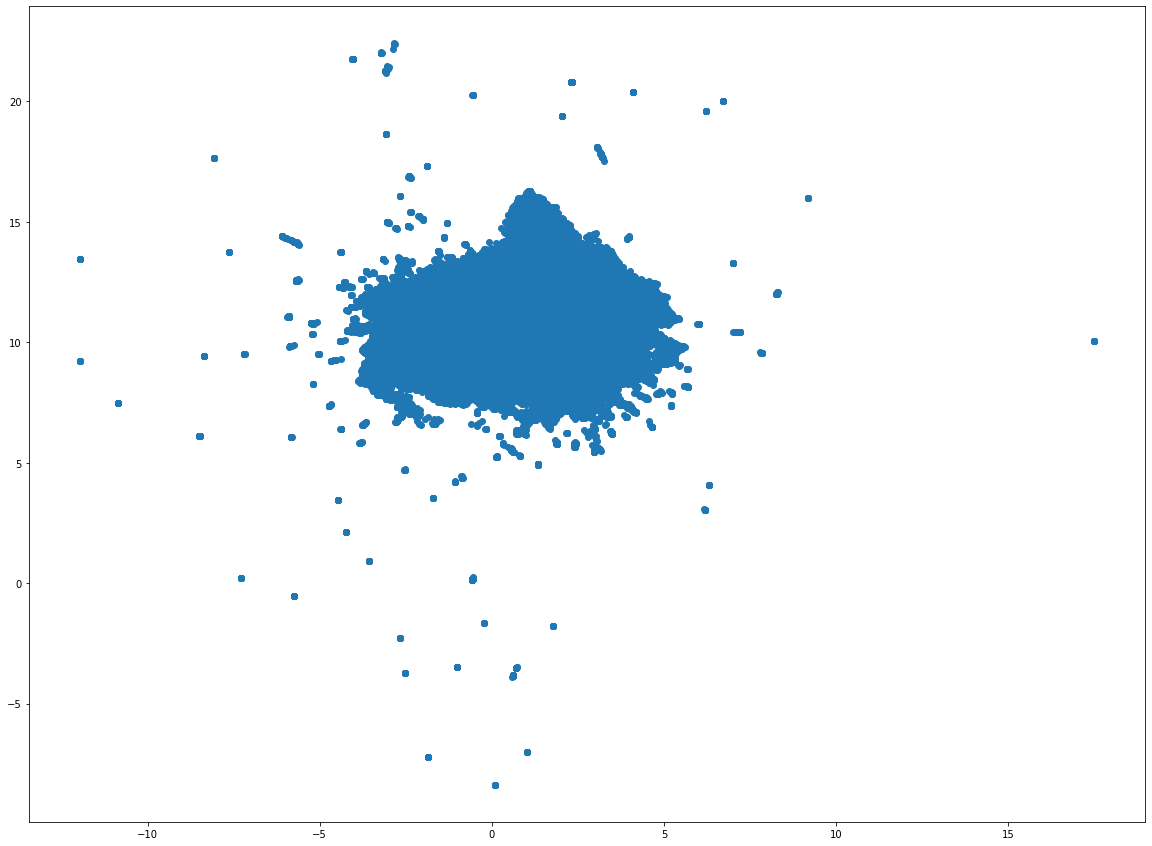

In [77]:
plot, standard_embedding = plt_usingUMAP(embedding_array)

In [78]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(embedding_array)
    
clusterer2 = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=100,
    cluster_selection_method = 'eom').fit(clusterable_embedding)

labels = clusterer2.labels_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


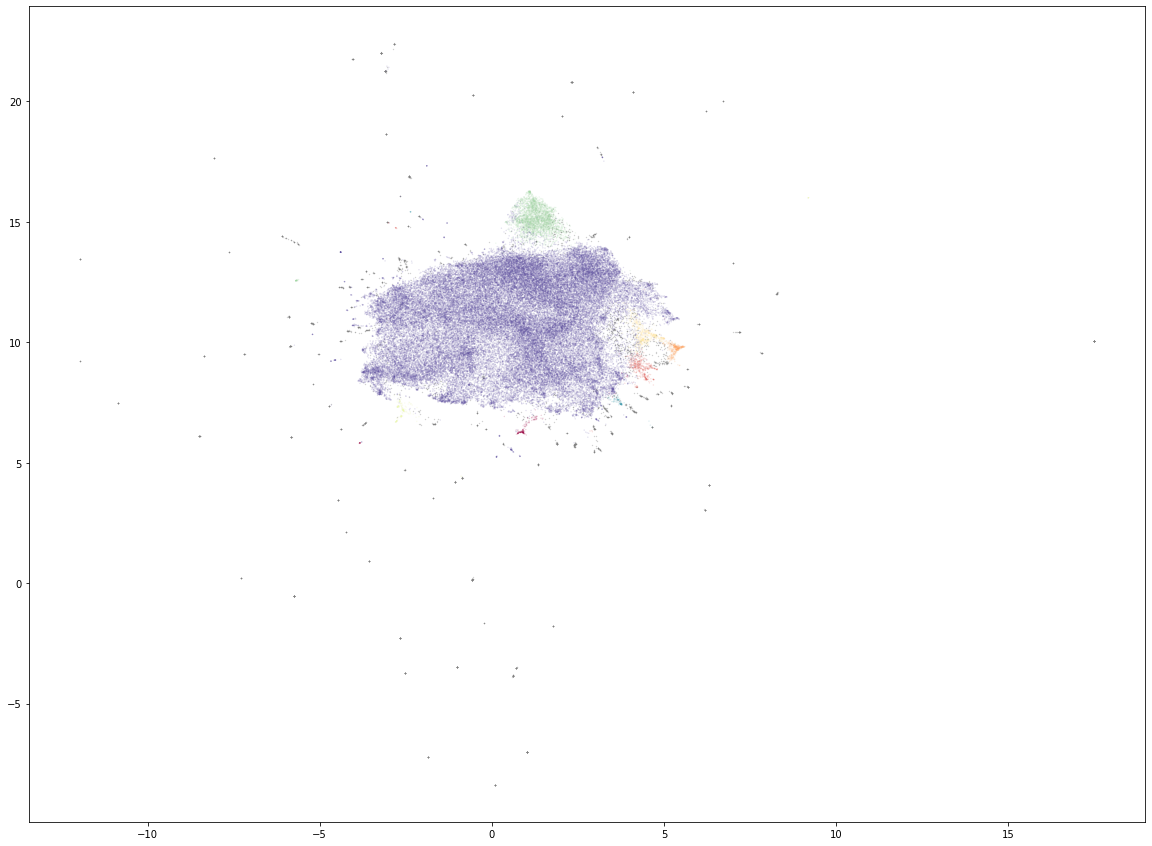

In [83]:
clustered = (labels >= 0)
plt.figure(figsize=(20, 15))
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            alpha = 0.25,
            cmap='Spectral')

In [106]:
from sklearn.metrics import silhouette_score
silhouette_score(clusterable_embedding, clusterer2.labels_)







-0.06876846

In [84]:
FreqDist(labels)

FreqDist({7: 61566, 5: 3122, -1: 2949, 3: 585, 1: 417, 2: 346, 0: 165, 4: 152, 6: 103})

In [85]:
hydrated_data2['cluster'] = clusterer2.labels_
hydrated_data2['x'] = standard_embedding[:,0]
hydrated_data2['y'] = standard_embedding[:,1]

In [86]:
import palettable
from palettable.wesanderson import Aquatic1_5, Moonrise1_5, Mendl_4
import seaborn as sns
colors = np.append(np.array(Mendl_4.mpl_colors), np.array(Moonrise1_5.mpl_colors))
colors

array([0.87058824, 0.55294118, 0.7254902 , 0.72156863, 0.75294118,
       0.96470588, 0.81176471, 0.57647059, 0.52941176, 0.36078431,
       0.50196078, 0.8       , 0.44705882, 0.79215686, 0.86666667,
       0.94117647, 0.64705882, 0.69019608, 0.54901961, 0.52156863,
       0.21176471, 0.76470588, 0.70588235, 0.46666667, 0.98039216,
       0.81568627, 0.38823529])

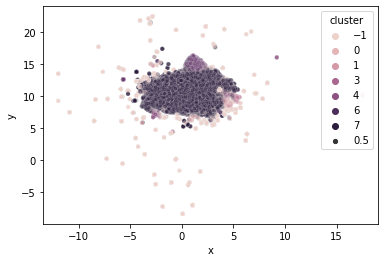

In [87]:
#plot data with seaborn
facet = sns.scatterplot(data=hydrated_data2, x='x', y='y', hue='cluster', 
                        legend=True, 
                        alpha=0.25,
                       size = 0.5)

In [26]:
import pickle
infile = open('top_yellow_peril','rb')
top_yellow_peril = pickle.load(infile)
infile.close()

infile = open('top_counterhate_mm','rb')
top_counterhate_mm = pickle.load(infile)
infile.close()

infile = open('top_peril_hate','rb')
top_peril_hate = pickle.load(infile)
infile.close()

In [88]:
hydrated_data2.reset_index(level = 0, inplace = True)
hydrated_data2['yellow_peril'] = np.where(hydrated_data2['tweet_id'].isin(top_yellow_peril['tweet_id']), 1, 0)
hydrated_data2['mm_counterhate'] = np.where(hydrated_data2['tweet_id'].isin(top_counterhate_mm['tweet_id']), 1, 0)
hydrated_data2['yp_hate'] = np.where(hydrated_data2['tweet_id'].isin(top_peril_hate['tweet_id']), 1, 0)
#hydrated_data2 = hydrated_data2.set_index('tweet_id')

In [89]:
hydrated_data2.to_csv('clustering_data.csv')

# Counterhate

In [91]:
random_state = 12345678
counterhate_tweets = hydrated_data1.loc[hydrated_data1.Label == 'Counterhate']

#ensure that the dimensions are the same
ids = counterhate_tweets['tweet_id'].tolist()
counterhate_embeddings = embeddings[embeddings[0].isin(ids)]

id2 = counterhate_embeddings[0].tolist()
counterhate_tweets2 = counterhate_tweets[counterhate_tweets['tweet_id'].isin(id2)]
counterhate_tweets2 = counterhate_tweets2.set_index('tweet_id')
counterhate_tweets2 = counterhate_tweets2.loc[id2]

counterhate_embeddings = counterhate_embeddings.iloc[: , 1:]
counterhate_embedding_array = counterhate_embeddings.to_numpy()

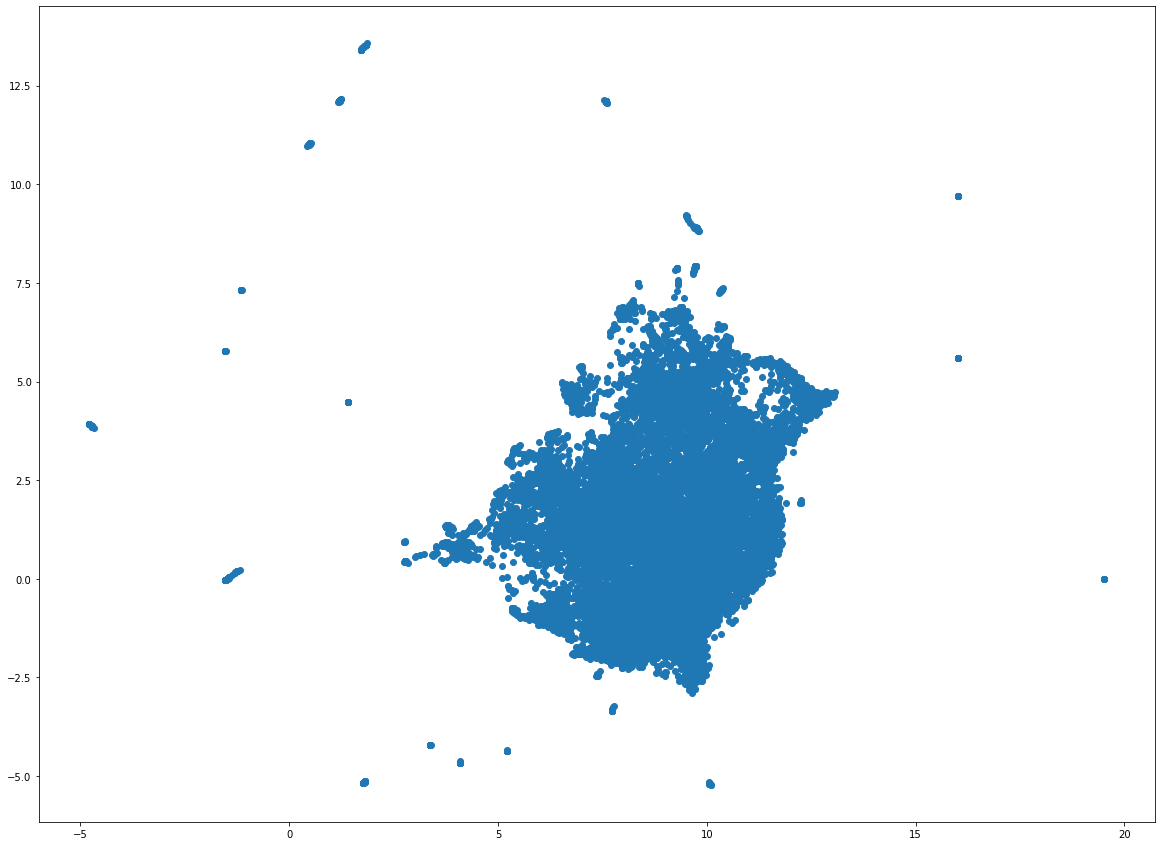

In [93]:
plot, counter_standard_embedding = plt_usingUMAP(counterhate_embedding_array)
clusterable_embedding2 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(counterhate_embedding_array)
    
counter_clusterer = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=100,
    cluster_selection_method = 'eom').fit(clusterable_embedding2)

labels = counter_clusterer.labels_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


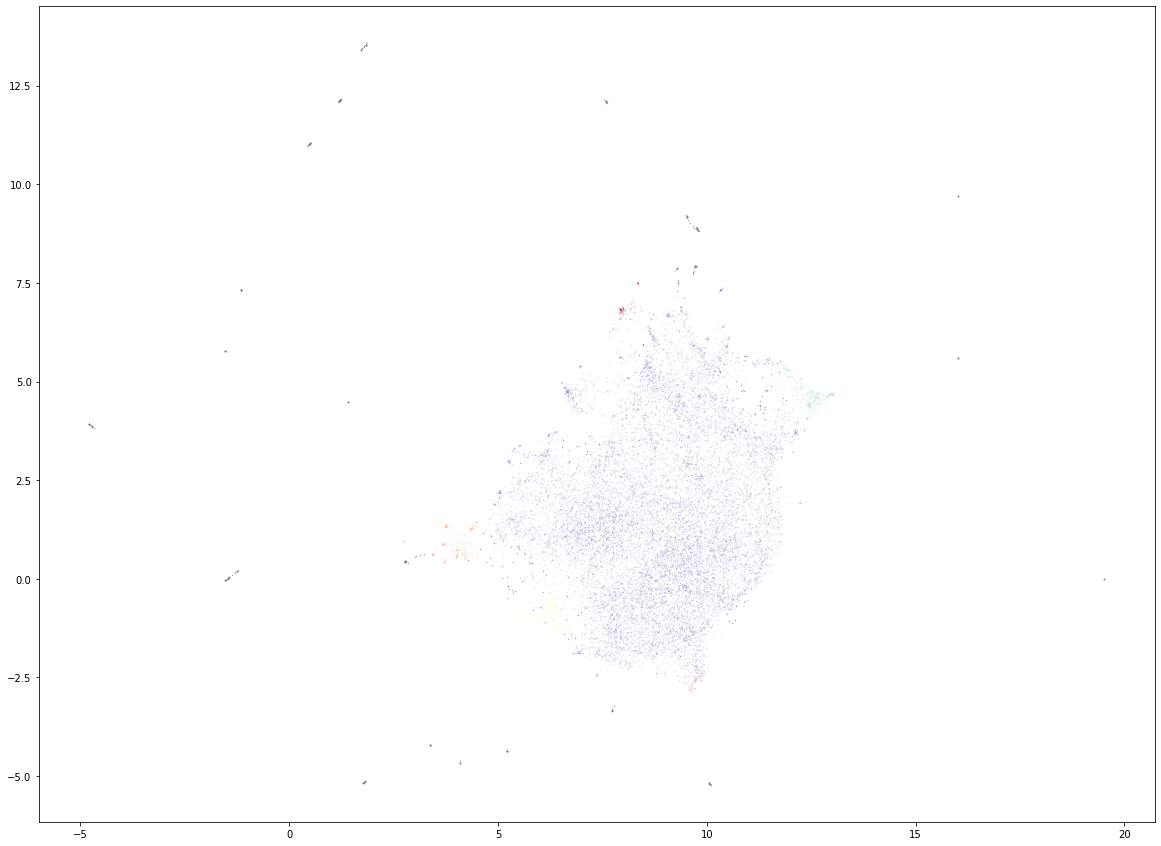

In [94]:
clustered = (labels >= 0)
plt.figure(figsize=(20, 15))
plt.scatter(counter_standard_embedding[~clustered, 0],
            counter_standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1)
plt.scatter(counter_standard_embedding[clustered, 0],
            counter_standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            alpha = 0.25,
            cmap='Spectral')

In [95]:
FreqDist(labels)

FreqDist({4: 12968, -1: 548, 3: 360, 2: 344, 1: 203, 0: 193})

In [96]:
counterhate_tweets2['cluster'] = counter_clusterer.labels_
counterhate_tweets2['x'] = counter_standard_embedding[:,0]
counterhate_tweets2['y'] = counter_standard_embedding[:,1]
counterhate_tweets2.reset_index(level = 0, inplace = True)
counterhate_tweets2['model_minority'] = np.where(counterhate_tweets2['tweet_id'].isin(top_counterhate_mm['tweet_id']), 1, 0)

In [97]:
counterhate_tweets2.to_csv('counterhate_clustering.csv')

# Hate Tweets Only

In [98]:
hate_tweets = hydrated_data1.loc[hydrated_data1.Label == 'Hate']

#ensure that the dimensions are the same
ids = hate_tweets['tweet_id'].tolist()
hate_embeddings = embeddings[embeddings[0].isin(ids)]

id2 = hate_embeddings[0].tolist()
hate_tweets2 = hate_tweets[hate_tweets['tweet_id'].isin(id2)]
hate_tweets2 = hate_tweets2.set_index('tweet_id')
hate_tweets2 = hate_tweets2.loc[id2]

hate_embeddings = hate_embeddings.iloc[: , 1:]
hate_embedding_array = hate_embeddings.to_numpy()

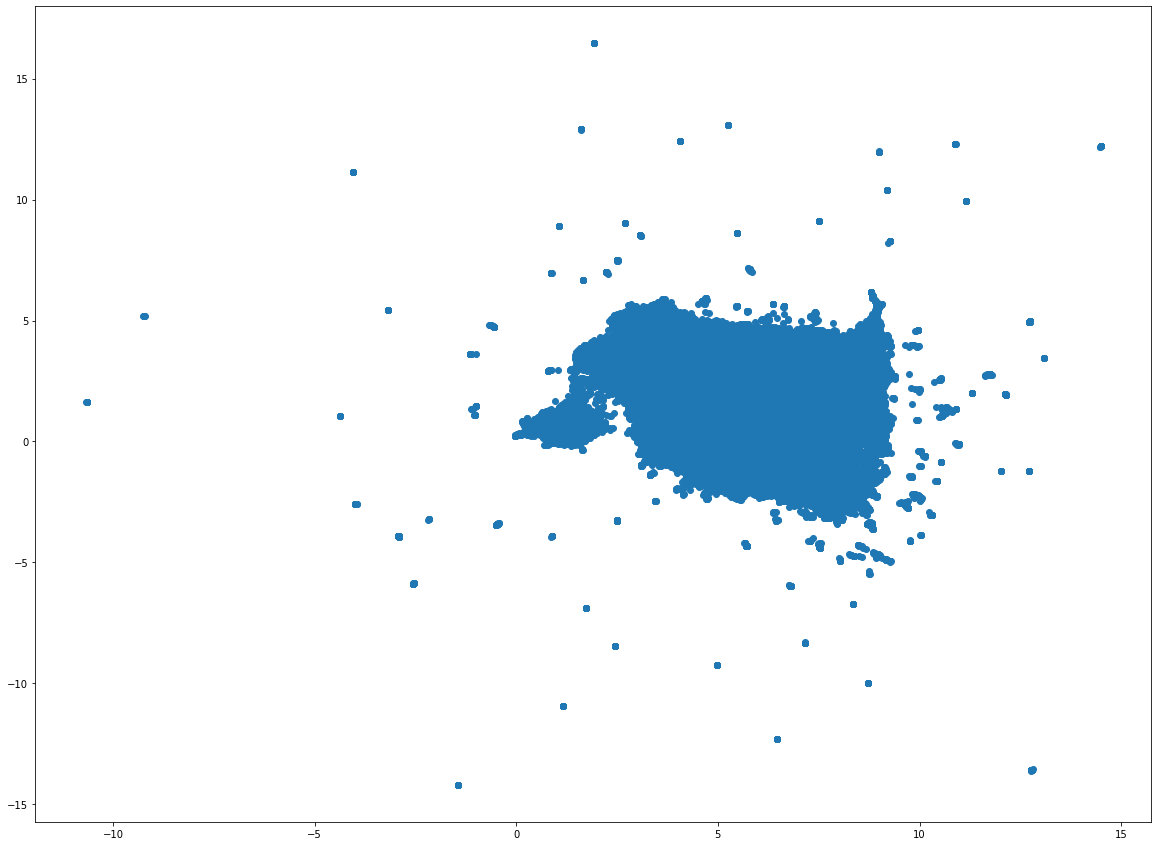

In [99]:
plot, hate_standard_embedding = plt_usingUMAP(hate_embedding_array)
clusterable_embedding3 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(hate_embedding_array)
    
hate_clusterer = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=100,
    cluster_selection_method = 'eom').fit(clusterable_embedding3)

labels = hate_clusterer.labels_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


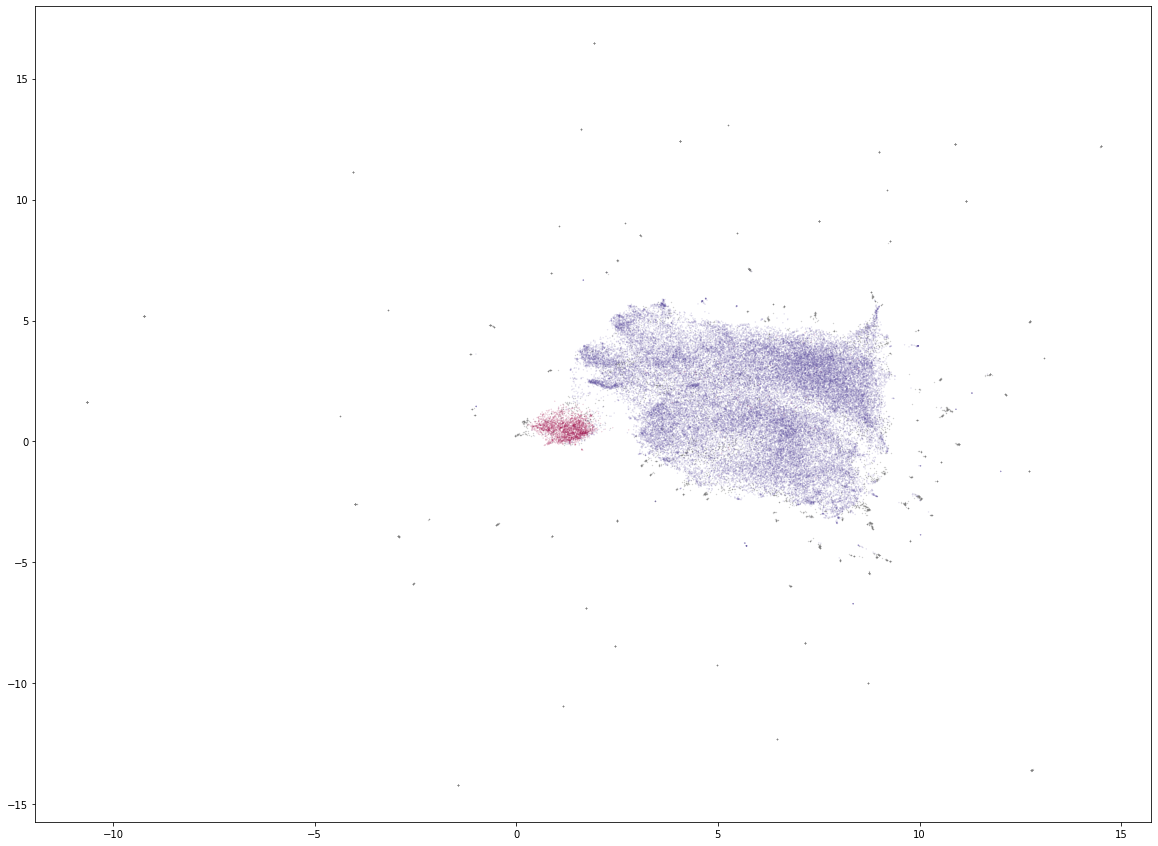

In [100]:
clustered = (labels >= 0)
plt.figure(figsize=(20, 15))
plt.scatter(hate_standard_embedding[~clustered, 0],
            hate_standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(hate_standard_embedding[clustered, 0],
            hate_standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            alpha = 0.25,
            cmap='Spectral')

In [101]:
hate_tweets2['cluster'] = hate_clusterer.labels_
hate_tweets2['x'] = hate_standard_embedding[:,0]
hate_tweets2['y'] = hate_standard_embedding[:,1]
hate_tweets2.reset_index(level = 0, inplace = True)
hate_tweets2['yellow_peril'] = np.where(hate_tweets2['tweet_id'].isin(top_peril_hate['tweet_id']), 1, 0)

In [102]:
FreqDist(hate_clusterer.labels_)

FreqDist({1: 48301, -1: 4009, 0: 2479})

In [103]:
hate_tweets2.to_csv('hate_clustering.csv')

In [105]:
FreqDist(hydrated_data1.Label)

FreqDist({'Hate': 57494, 'Counterhate': 14894})